## Mogul Data Challenge

### Objective: Identify the factors affecting hotel performance in Colorado 

In this case study I will assume that a client of mine is interested in openinig a new budget/midprice/economy hotel in Colorado and wants to understand the hotel market before they move forward with their hotel plans

## 1. Import the libraries and data

In [288]:
#libraries for data manipulation
import pandas as pd
import numpy as np

#libraries for visualization
import matplotlib.pyplot as plt
import seaborn as sns

#formatting numbers to 2 decimal places for readibility
pd.options.display.float_format = '{:.2f}'.format

#suppressing warnings
import warnings
warnings.filterwarnings('ignore')

#library for matching hotel names
import fuzzymatcher

# sklearn modules for data preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

#sklearn modules for Model Selection and Evaluation
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error,r2_score

### 1.1 Creating a visualization class to create visualizations faster

In [217]:
#visualization class to plot the right plots based on the type of the feature

class viz:
    
    def __init__(self,width,height,data):
        self.fig_size = plt.figure(figsize = (width,height))
        self.df = data

    
    def get_heatmap(self,columns):
        sns.set()
        numerical_features = self.df[columns]
        sns.heatmap(numerical_features.corr(),annot=True, cmap='Spectral', vmin=-1, vmax=1)
        plt.show()
        
    def get_boxplot(self,title,categorical_col,numeric_col):
        sns.set()
        cat_col=self.df[categorical_col]
        numeric_col = self.df[numeric_col]
        sns.boxplot(x=cat_col,y=numeric_col)
        plt.title(title)
        plt.show()
    
    def get_countplot(self,column,hue,title):
        sns.set()
        col = self.df[column]
        hue = self.df[hue]
        sns.countplot(x=col,hue= hue)
        plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
        plt.title(title)
        plt.xticks(rotation = 90)
        plt.show()

Read the datasets as a pandas dataframe and checking for basic info

In [219]:
hotel_df1=pd.read_csv('Denver Hotel Info.csv')
print(hotel_df1.info())
print(hotel_df1.head(3))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 380 entries, 0 to 379
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Hotel Name        380 non-null    object
 1   Brand Name        380 non-null    object
 2   City              380 non-null    object
 3   State             380 non-null    object
 4   Country           380 non-null    object
 5   Class Type        380 non-null    object
 6   Location Type     380 non-null    object
 7   Price Type        380 non-null    object
 8   Restaurant (Y/N)  380 non-null    object
 9   Conference (Y/N)  380 non-null    object
 10  Spa (Y/N)         380 non-null    object
 11  Total Rooms       380 non-null    int64 
 12  Floor Count       380 non-null    int64 
 13  Rate              380 non-null    object
dtypes: int64(2), object(12)
memory usage: 41.7+ KB
None
                              Hotel Name             Brand Name      City  \
0             11th Avenue

The first dataset has 14 columns and 380 rows with 12 object type and 2 integer type columns

In [317]:
hotel_df2=pd.read_csv('Denver Hotel Performance.csv')
print(hotel_df2.info())
print(hotel_df2.head(3))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 332 entries, 0 to 331
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Name            332 non-null    object 
 1   Response rate   331 non-null    object 
 2   Popularity      249 non-null    object 
 3   Room Score      329 non-null    float64
 4   Service Score   330 non-null    float64
 5   Food Score      295 non-null    float64
 6   Location Score  315 non-null    float64
 7   Overall Score   332 non-null    int64  
dtypes: float64(4), int64(1), object(3)
memory usage: 20.9+ KB
None
                       Name Response rate Popularity  Room Score  \
0             A Bar D Motel            0%        68%         NaN   
1  AC Hotel Denver Downtown           94%        90%       65.00   
2            Ahwahnee Motel            0%        11%       47.00   

   Service Score  Food Score  Location Score  Overall Score  
0          50.00         NaN          100.0

The second dataset has 8 columns and 332 rows with 3 object type, 4 float type  and 1 integer type columns

### Initial Observations:

1) There are no unique id columns in either dataset to merge the two datasets
2) We need to merge the datasets by their names as this is the only unique identifier connecting both datasets
3) hotel_df1 is complete with no missing values and hence does not require any treatment
4) hotel_df2 has some missing values and requires further investigation before merging. 

## 2 Missing value imputation and analysis 

I will investigate only hotel_df2 for missing values as hotel_df1 is complete with no missing values

### 2.1 Converting Formats

Response rate and Popularity will be converted to numeric format to check for correlations with other metrics.

In [318]:
hotel_df2['Response rate']=hotel_df2['Response rate'].str.rstrip("%").astype(float)
hotel_df2['Popularity']=hotel_df2['Popularity'].str.rstrip("%").astype(float)
hotel_df2[['Response rate','Popularity']].head()

,Response rate,Popularity
0,0.00,68.00
1,94.00,90.00
2,0.00,11.00
3,0.00,57.00
4,97.00,72.00


### 2.2 Checking for correlations

Selecting all the numeric features to check for high correlation

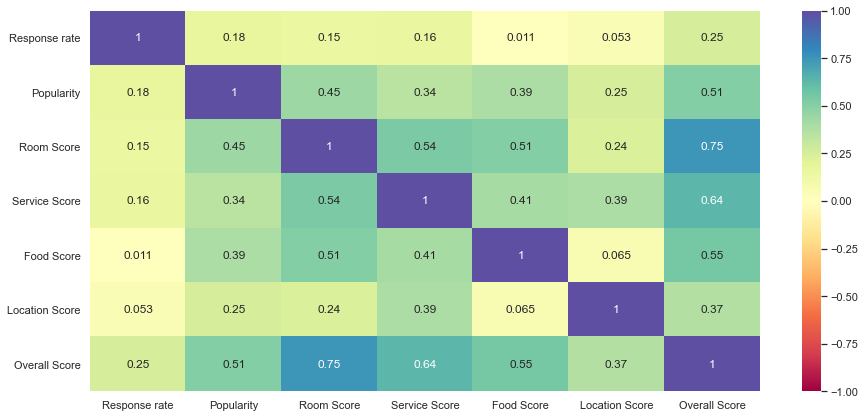

In [308]:
numerical_features=hotel_df2.select_dtypes(include=['int64','float64'])
data=viz(15,7,hotel_df2)
data.get_heatmap(numerical_features.columns)

There seems to be a strong positive correlation between the overall score, popularity,room score, service score and the food score which is not surprising. There is also positive correlation between other metrics. 

Checking the summary stats of numeric variables to understand their distrubution before imputing with mean/median

In [31]:
numerical_features.describe()

,Response rate,Popularity,Room Score,Service Score,Food Score,Location Score,Overall Score
count,331.00,249.00,329.00,330.00,295.00,315.00,332.00
mean,43.57,56.68,59.34,77.59,63.90,84.90,77.08
std,33.19,26.21,19.39,16.25,21.50,14.75,11.90
min,0.00,0.00,0.00,0.00,0.00,0.00,42.00
25%,9.00,38.00,48.00,73.00,50.00,80.00,69.75
50%,45.00,58.00,62.00,80.00,68.00,87.00,80.00
75%,70.00,78.00,74.00,87.00,78.50,94.00,86.00
max,100.00,100.00,100.00,100.00,100.00,100.00,99.00


Since Response rate,Location score, Service score and Room score have small number of missing values and they seem to have normal distributions.Therefore I will impute the missing values with their mean to fill the gap

### 2.3 Imputation

In [319]:
hotel_df2['Location Score'] = hotel_df2['Location Score'].fillna(hotel_df2['Location Score'].mean())
hotel_df2['Service Score'] = hotel_df2['Service Score'].fillna(hotel_df2['Service Score'].mean())
hotel_df2['Room Score'] = hotel_df2['Room Score'].fillna(hotel_df2['Room Score'].mean())
hotel_df2['Response rate'] = hotel_df2['Response rate'].fillna(hotel_df2['Response rate'].median())
hotel_df2.isna().sum()

Name               0
Response rate      0
Popularity        83
Room Score         0
Service Score      0
Food Score        37
Location Score     0
Overall Score      0
dtype: int64

Since The Popularity is highly correlated with the overall score and has 25% of missing value. I beleive that we can safely drop this column as simple impuation would not yield accurate results. As it is highly correlated with overall score, it might not add much information and hence does not warrant the extra effort of advanced imputation at this stage.Food Score metric will be imputed after merging with the other dataset as some of the hotels might not have restaurants. Imputing food score to hotels with no restaurants would not be correct and hence I will investigate this metric at a later stage with the complete data.

### 2.4 Drop column

In [320]:
hotel_df2.drop(labels = ['Popularity'],inplace=True,axis=1)
print(hotel_df2.shape)
print(hotel_df2.columns)

(332, 7)
Index(['Name', 'Response rate', 'Room Score', 'Service Score', 'Food Score',
       'Location Score', 'Overall Score'],
      dtype='object')


## 3 Fuzzy matching

I will use the fuzzymatcher package to match the hotel names and combine the two dataframes as this package is good to use when we have a small to medium size dataframe. 

The fuzzymatcher function will comapre the hotel names from both the datasets and will provide the best_match_score metric which can be used to validate the comparision and delete the rows where the hotel names do not seem to match.

In [321]:
matched_results = fuzzymatcher.fuzzy_left_join(hotel_df1,hotel_df2,left_on='Hotel Name',right_on='Name')
matched_results.sort_values(by=['best_match_score'],ascending=False).head()

,best_match_score,__id_left,__id_right,Hotel Name,Brand Name,City,State,Country,Class Type,Location Type,...,Total Rooms,Floor Count,Rate,Name,Response rate,Room Score,Service Score,Food Score,Location Score,Overall Score
1286,1.25,54_left,44_right,Comfort Suites Highlands Ranch Denver Tech Cen...,Comfort Suites,Highlands Ranch,CO,United States,Upper Midscale Class,Suburban,...,73,4,$50,Comfort Suites Highlands Ranch Denver Tech Cen...,86.00,71.00,91.00,69.00,92.00,85
562,1.18,12_left,293_right,Autograph Collection The Brown Palace Hotel & Spa,Autograph Collection,Denver,CO,United States,Upper Upscale Class,Urban,...,241,9,$426,"The Brown Palace Hotel and Spa, Autograph Coll...",12.00,60.00,84.00,84.00,89.00,88
3308,1.05,206_left,174_right,Hyatt Regency Denver at Colorado Convention Ce...,Hyatt Regency,Denver,CO,United States,Upper Upscale Class,Urban,...,1100,37,"$1,176",Hyatt Regency Denver at Colorado Convention Ce...,53.00,80.00,89.00,74.00,90.00,89
3031,1.02,178_left,150_right,Home2 Suites by Hilton Denver West Federal Center,Home2 Suites by Hilton,Lakewood,CO,United States,Upper Midscale Class,Suburban,...,107,4,$60,Home2 Suites by Hilton Denver West - Federal C...,13.00,60.00,80.00,57.00,83.00,88
735,1.01,25_left,22_right,Best Western Plus Inn & Suites Denver Internat...,Best Western Plus,Denver,CO,United States,Upper Midscale Class,Airport,...,101,3,$122,Best Western Plus Denver International Airport...,22.00,48.00,80.00,64.00,85.00,73


In [322]:
#reseting the index and getting some basic info on the matched dataset 
matched_results.reset_index(inplace=True)
matched_results.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 380 entries, 0 to 379
Data columns (total 25 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   index             380 non-null    int64  
 1   best_match_score  380 non-null    float64
 2   __id_left         380 non-null    object 
 3   __id_right        380 non-null    object 
 4   Hotel Name        380 non-null    object 
 5   Brand Name        380 non-null    object 
 6   City              380 non-null    object 
 7   State             380 non-null    object 
 8   Country           380 non-null    object 
 9   Class Type        380 non-null    object 
 10  Location Type     380 non-null    object 
 11  Price Type        380 non-null    object 
 12  Restaurant (Y/N)  380 non-null    object 
 13  Conference (Y/N)  380 non-null    object 
 14  Spa (Y/N)         380 non-null    object 
 15  Total Rooms       380 non-null    int64  
 16  Floor Count       380 non-null    int64  
 1

### 3.1 Simple validation of matches

In [323]:
matched_results.tail(15)  

,index,best_match_score,__id_left,__id_right,Hotel Name,Brand Name,City,State,Country,Class Type,...,Total Rooms,Floor Count,Rate,Name,Response rate,Room Score,Service Score,Food Score,Location Score,Overall Score
365,5629,0.39,365_left,305_right,Westin Denver Downtown,Westin,Denver,CO,United States,Upper Upscale Class,...,430,19,$566,The Westin Denver Downtown,96.00,68.00,75.00,59.00,90.00,85
366,5630,0.51,366_left,306_right,Westin Denver International Airport,Westin,Denver,CO,United States,Upper Upscale Class,...,519,14,$298,The Westin Denver International Airport,30.00,84.00,77.00,64.00,87.00,91
367,5631,0.39,367_left,307_right,Westin Westminster,Westin,Westminster,CO,United States,Upper Upscale Class,...,370,14,$323,The Westin Westminster,46.00,75.00,79.00,65.00,89.00,86
368,5632,0.10,368_left,191_right,Westway Motel,Independent,Denver,CO,United States,Economy Class,...,23,2,$33,La Vista Motel,0.00,33.00,75.00,NaN,84.90,59
369,5681,0.30,369_left,326_right,White Rock Motel & RV Park,Independent,Denver,CO,United States,Economy Class,...,33,1,$43,White Rock Motel,0.00,62.00,71.00,NaN,75.00,64
370,5730,0.59,370_left,327_right,White Swan Motel,Independent,Denver,CO,United States,Economy Class,...,20,1,$32,White Swan Motel,0.00,50.00,86.00,NaN,0.00,57
371,5731,0.85,371_left,328_right,Wingate by Wyndham Denver Airport,Wingate by Wyndham,Denver,CO,United States,Midscale Class,...,123,4,$119,Wingate by Wyndham Denver Airport,5.00,74.00,81.00,50.00,94.00,88
372,5732,0.41,372_left,328_right,Wingate by Wyndham Greenwood Village Denver Tech,Wingate by Wyndham,Greenwood Village,CO,United States,Midscale Class,...,86,3,$109,Wingate by Wyndham Denver Airport,5.00,74.00,81.00,50.00,94.00,88
373,5770,0.72,373_left,329_right,Wolf's Motor Inn,Independent,Aurora,CO,United States,Economy Class,...,33,2,$33,Wolf’S Motor Inn,0.00,25.00,50.00,NaN,100.00,53
374,5771,0.53,374_left,330_right,WoodSpring Suites Aurora Denver Airport,WoodSpring Suites,Aurora,CO,United States,Economy Class,...,122,4,$22,WoodSpring Suites Denver Aurora,89.00,32.00,50.00,56.00,88.00,58


In [324]:
matched_results.head(15)

,index,best_match_score,__id_left,__id_right,Hotel Name,Brand Name,City,State,Country,Class Type,...,Total Rooms,Floor Count,Rate,Name,Response rate,Room Score,Service Score,Food Score,Location Score,Overall Score
0,0,0.01,0_left,166_right,11th Avenue Hotel & Hostel,Independent,Denver,CO,United States,Economy Class,...,100,3,$40,Hotel The Timbers,60.00,47.00,56.00,66.00,68.00,72
1,50,0.33,1_left,0_right,A & D Motel,Independent,Lakewood,CO,United States,Economy Class,...,12,1,$33,A Bar D Motel,0.00,59.34,50.00,NaN,100.00,63
2,51,0.14,2_left,50_right,AC Hotels by Marriott Denver Downtown,AC Hotels by Marriott,Denver,CO,United States,Upscale Class,...,223,19,$226,Courtyard by Marriott Denver Downtown,64.00,65.00,84.00,48.00,90.00,86
3,54,-0.26,3_left,298_right,Affordable Inn Wheat Ridge,Independent,Wheat Ridge,CO,United States,Economy Class,...,100,2,$40,The Inn at Cherry Creek,0.00,67.00,100.00,NaN,84.90,95
4,114,0.03,4_left,2_right,All Inn Motel,Independent,Denver,CO,United States,Economy Class,...,54,4,$27,Ahwahnee Motel,0.00,47.00,50.00,NaN,84.90,75
5,213,0.07,5_left,4_right,aloft Hotel Broomfield Denver,aloft Hotel,Broomfield,CO,United States,Upscale Class,...,139,4,$146,Aloft Denver Downtown,97.00,61.00,92.00,61.00,91.00,83
6,282,0.41,6_left,70_right,aloft Hotel Denver Airport At Gateway Park,aloft Hotel,Aurora,CO,United States,Upscale Class,...,144,5,$66,Denver Airport Marriott at Gateway Park,47.00,60.00,80.00,67.00,86.00,82
7,351,0.12,7_left,51_right,aloft Hotel Denver North Westminster,aloft Hotel,Westminster,CO,United States,Upscale Class,...,120,5,$142,Courtyard by Marriott Denver North/Westminster,68.00,85.00,88.00,72.00,94.00,87
8,420,-0.06,8_left,13_right,American Motel,Independent,Wheat Ridge,CO,United States,Economy Class,...,138,5,$43,Aurora Motel,0.00,50.00,80.00,NaN,84.90,61
9,469,0.33,9_left,6_right,Americas Best Value Inn Denver,Americas Best Value Inn,Denver,CO,United States,Economy Class,...,112,2,$37,Americas Best Value Inn Lakewood South Tacoma,46.00,24.00,60.00,37.00,56.00,55


From the above two tables it looks like scores below 0.15 are not good matches. I will drop the rows where the best_match_score is below 0.15

In [325]:
matched_results=matched_results[matched_results['best_match_score']>0.15]
matched_results.reset_index(inplace=True)
matched_results.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 255 entries, 0 to 254
Data columns (total 26 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   level_0           255 non-null    int64  
 1   index             255 non-null    int64  
 2   best_match_score  255 non-null    float64
 3   __id_left         255 non-null    object 
 4   __id_right        255 non-null    object 
 5   Hotel Name        255 non-null    object 
 6   Brand Name        255 non-null    object 
 7   City              255 non-null    object 
 8   State             255 non-null    object 
 9   Country           255 non-null    object 
 10  Class Type        255 non-null    object 
 11  Location Type     255 non-null    object 
 12  Price Type        255 non-null    object 
 13  Restaurant (Y/N)  255 non-null    object 
 14  Conference (Y/N)  255 non-null    object 
 15  Spa (Y/N)         255 non-null    object 
 16  Total Rooms       255 non-null    int64  
 1

### 3.2 Drop columns 

I will drop columns that are not useful and provide any additonal information from the dataset

In [326]:
matched_results.drop(labels=['level_0','index','best_match_score','__id_left','__id_right','Hotel Name','State','Country'],inplace=True,axis=1)
hotel_df=matched_results.copy()
hotel_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 255 entries, 0 to 254
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Brand Name        255 non-null    object 
 1   City              255 non-null    object 
 2   Class Type        255 non-null    object 
 3   Location Type     255 non-null    object 
 4   Price Type        255 non-null    object 
 5   Restaurant (Y/N)  255 non-null    object 
 6   Conference (Y/N)  255 non-null    object 
 7   Spa (Y/N)         255 non-null    object 
 8   Total Rooms       255 non-null    int64  
 9   Floor Count       255 non-null    int64  
 10  Rate              255 non-null    object 
 11  Name              255 non-null    object 
 12  Response rate     255 non-null    float64
 13  Room Score        255 non-null    float64
 14  Service Score     255 non-null    float64
 15  Food Score        243 non-null    float64
 16  Location Score    255 non-null    float64
 1

In [327]:
#taking a look at the final dataset 
hotel_df.head(3)

,Brand Name,City,Class Type,Location Type,Price Type,Restaurant (Y/N),Conference (Y/N),Spa (Y/N),Total Rooms,Floor Count,Rate,Name,Response rate,Room Score,Service Score,Food Score,Location Score,Overall Score
0,Independent,Lakewood,Economy Class,Suburban,Budget,N,N,N,12,1,$33,A Bar D Motel,0.00,59.34,50.00,NaN,100.00,63
1,aloft Hotel,Aurora,Upscale Class,Suburban,Midprice,N,N,N,144,5,$66,Denver Airport Marriott at Gateway Park,47.00,60.00,80.00,67.00,86.00,82
2,Americas Best Value Inn,Denver,Economy Class,Airport,Budget,N,N,N,112,2,$37,Americas Best Value Inn Lakewood South Tacoma,46.00,24.00,60.00,37.00,56.00,55


### 3.3 Checking for duplicate hotel names

As there is chance that there might be duplciate hotels still listed in the dataset due to fuzzymatching, I will check for any duplicates and delete any duplicate rows to ensure that we have unique hotels in our dataset.

In [328]:
hotel_df.drop_duplicates(subset=['Name'],keep='first',inplace=True,ignore_index=True)
hotel_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 190 entries, 0 to 189
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Brand Name        190 non-null    object 
 1   City              190 non-null    object 
 2   Class Type        190 non-null    object 
 3   Location Type     190 non-null    object 
 4   Price Type        190 non-null    object 
 5   Restaurant (Y/N)  190 non-null    object 
 6   Conference (Y/N)  190 non-null    object 
 7   Spa (Y/N)         190 non-null    object 
 8   Total Rooms       190 non-null    int64  
 9   Floor Count       190 non-null    int64  
 10  Rate              190 non-null    object 
 11  Name              190 non-null    object 
 12  Response rate     190 non-null    float64
 13  Room Score        190 non-null    float64
 14  Service Score     190 non-null    float64
 15  Food Score        178 non-null    float64
 16  Location Score    190 non-null    float64
 1

After removing duplicates our final dataset has 190 unique hotels in Colorado

### 3.4 Investigating missing Food score metric

In [329]:
#creating a bool series for True and NaN values
bool_series=pd.isnull(hotel_df['Food Score'])
hotel_df[bool_series]

,Brand Name,City,Class Type,Location Type,Price Type,Restaurant (Y/N),Conference (Y/N),Spa (Y/N),Total Rooms,Floor Count,Rate,Name,Response rate,Room Score,Service Score,Food Score,Location Score,Overall Score
0,Independent,Lakewood,Economy Class,Suburban,Budget,N,N,N,12,1,$33,A Bar D Motel,0.00,59.34,50.00,NaN,100.00,63
15,Independent,Lakewood,Economy Class,Suburban,Budget,N,N,N,23,2,$47,Blue Sky Motel,0.00,56.00,100.00,NaN,100.00,62
16,Independent,Denver,Economy Class,Urban,Budget,N,N,N,33,2,$50,Branding Iron Motel,0.00,0.00,100.00,NaN,84.90,71
18,Independent,Lakewood,Economy Class,Suburban,Budget,N,N,N,18,1,$37,Chalet Motel,0.00,50.00,0.00,NaN,100.00,47
127,Independent,Denver,Economy Class,Urban,Budget,N,N,N,33,2,$46,Niagara Motel,0.00,83.00,57.00,NaN,84.90,63
128,Independent,Lakewood,Economy Class,Suburban,Budget,N,N,N,25,2,$43,Panorama Motel,0.00,70.00,80.00,NaN,80.00,62
146,Independent,Aurora,Economy Class,Suburban,Budget,N,N,N,46,2,$31,Riveria Motel,0.00,92.00,80.00,NaN,80.00,67
180,Independent,Denver,Economy Class,Urban,Budget,N,N,N,23,2,$47,Western Motel,12.00,60.00,100.00,NaN,100.00,62
181,Independent,Denver,Economy Class,Urban,Budget,Y,N,N,105,2,$45,Western Motor Inn of Denver,0.00,46.00,67.00,NaN,100.00,53
185,Independent,Denver,Economy Class,Suburban,Budget,N,N,N,33,1,$43,White Rock Motel,0.00,62.00,71.00,NaN,75.00,64


Only two of the hotels in the above list have restaurants and no food score. I will not impute the missing values for the food score as majority
 of the hotels without restaurants are the ones with no food score.

## 4 Exploratory Analysis

### 4.1 Converting rate into a numeric column

In [330]:
hotel_df['Rate'] = hotel_df['Rate'].str.replace("(\$|,)","",regex=True).astype(float)
hotel_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 190 entries, 0 to 189
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Brand Name        190 non-null    object 
 1   City              190 non-null    object 
 2   Class Type        190 non-null    object 
 3   Location Type     190 non-null    object 
 4   Price Type        190 non-null    object 
 5   Restaurant (Y/N)  190 non-null    object 
 6   Conference (Y/N)  190 non-null    object 
 7   Spa (Y/N)         190 non-null    object 
 8   Total Rooms       190 non-null    int64  
 9   Floor Count       190 non-null    int64  
 10  Rate              190 non-null    float64
 11  Name              190 non-null    object 
 12  Response rate     190 non-null    float64
 13  Room Score        190 non-null    float64
 14  Service Score     190 non-null    float64
 15  Food Score        178 non-null    float64
 16  Location Score    190 non-null    float64
 1

### 4.2 Checking for correlations

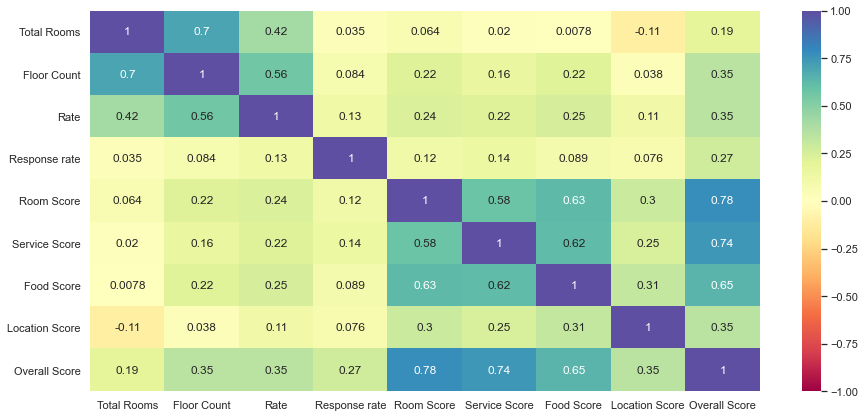

In [331]:
#extracting only the numeric features
data = viz(15,7,hotel_df)
numerical_features = hotel_df.select_dtypes(include=['int64','float64'])
data.get_heatmap(numerical_features.columns)

From the heatmap it is clear that Room Score, Service Score and Food Score have the highest positive relation with the Overall score.
Other notable correlated metrics are as follows

  a) Floor count and Total Rooms (As expected, more the floor more the number of rooms)
  
  b) Food Score and Room Score
  
  c) Food score and Service Score
  
  d) Floor count and Rate
  
  e) Room Score and Service
  
  f) Small negative correlation between the Total room and Location Score

### 4.3 Bivariate analysis

#### 4.3.1 Location Type

Analysis of the location type and Overall Score

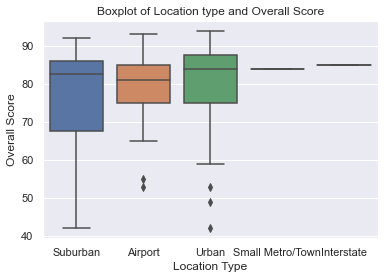

In [332]:
data.get_boxplot('Boxplot of Location type and Overall Score','Location Type','Overall Score')

From the above boxplot we can observe that Hotels in urban locations have slightly better overall ratings than other location types

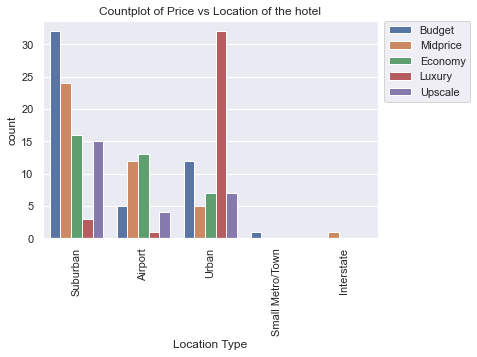

In [333]:
data.get_countplot('Location Type','Price Type','Countplot of Price vs Location of the hotel')

The countplot above further indicates that there are more Luxury hotels in urban areas than other location type. Also, our data shows that majority of the hotels are in either suburban, Airport or In Urban areas. Budget and Midprice hotels are more common in suburban areas whereas luxury hotels are common in Urban areas. Hotels near airports seem to cater mainly towards budget conscious clients as we mainly see Economy and Midprice hotels.

#### 4.3.2 Price and Structural Analysis

In [334]:
pd.pivot_table(hotel_df, values=['Rate', 'Overall Score','Floor Count', 'Total Rooms'],index=['Location Type','Price Type', 'Restaurant (Y/N)'],
                       aggfunc={'Rate': np.mean,'Overall Score': np.mean,'Floor Count': np.mean,'Total Rooms': np.mean})

Floor Count  Overall Score  \
Location Type    Price Type Restaurant (Y/N)                               
Airport          Budget     N                        2.50          60.00   
                            Y                        6.00          88.00   
                 Economy    N                        3.83          79.33   
                            Y                        6.00          74.00   
                 Luxury     Y                       14.00          91.00   
                 Midprice   N                        4.42          82.67   
                 Upscale    N                        4.50          88.50   
                            Y                        6.00          85.00   
Interstate       Midprice   N                        4.00          85.00   
Small Metro/Town Budget     N                        2.00          84.00   
Suburban         Budget     N                        2.42          63.85   
                            Y                        4.17          67.83   
                 Economy    N                        3.54          78.62   
                            Y                        4.00          82.67   
                 Luxury     Y                        7.00          88.67   
                 Midprice   N                        4.24          83.76   
                            Y                        7.00          86.00   
                 Upscale    N                        4.40          86.80   
                            Y                        7.80          85.70   
Urban            Budget     N                        2.44          64.78   
                            Y                        5.33          60.00   
                 Economy    N                        5.50          72.50   
                            Y                        3.00          68.00   
                 Luxury     N                       12.00          85.29   
                            Y                       12.44          86.76   
                 Midprice   N                        7.75          82.25   
                            Y                       21.00          83.00   
                 Upscale    N                        7.29          82.43   

                                               Rate  Total Rooms  
Location Type    Price Type Restaurant (Y/N)                      
Airport          Budget     N                 56.75       119.00  
                            Y                121.00       163.00  
                 Economy    N                103.83       109.08  
                            Y                153.00       255.00  
                 Luxury     Y                298.00       519.00  
                 Midprice   N                101.75       123.17  
                 Upscale    N                131.00       111.00  
                            Y                 92.50       162.50  
Interstate       Midprice   N                145.00        84.00  
Small Metro/Town Budget     N                 41.00        26.00  
Suburban         Budget     N                 46.08        89.77  
                            Y                 90.50       146.67  
                 Economy    N                 95.23        98.38  
                            Y                 97.00       131.67  
                 Luxury     Y                188.67       545.67  
                 Midprice   N                106.19       122.10  
                            Y                188.67       191.67  
                 Upscale    N                109.40       111.60  
                            Y                216.80       234.30  
Urban            Budget     N                 68.67        67.56  
                            Y                 80.67       185.33  
                 Economy    N                127.33        95.50  
                            Y                 59.00       130.00  
                 Luxury     N                210.29       192.57  
                       

##### Observations
1) Having a restaurant in the hotel allows the hotel management to charge higher rate and also seems to improve the overall score of the hotel
2) Midprice hotels in sub-urban areas with restaurants has a higher overall score than Economy or Budget hotels and has an average price of $188 which is higher than economy or budget hotels in any other location types. 
3) Midprice hotels in sub-urban areas with restaurants on average has 190 rooms and 7 floors which is not signifcantly larger than economy or budget hotels in different location types and hence is the optimal size for the new hotel.

#### 4.3.3 City analysis

In [257]:
#no of hotels in different cities in and around Denver
hotel_df['City'].value_counts(normalize=True).nlargest(5)*100

Denver        57.37
Lakewood      10.53
Aurora         9.47
Westminster    4.21
Golden         4.21
Name: City, dtype: float64

In [255]:
pd.pivot_table(hotel_df, values=['Rate', 'Overall Score'],index=['City'],
                       aggfunc={'Rate': np.mean,'Overall Score': np.mean})

,Overall Score,Rate
City,,
Arvada,87.00,119.00
Aurora,70.11,88.78
Brighton,82.50,107.50
Byers,84.00,41.00
Castle Rock,85.00,145.00
Centennial,85.00,133.00
Denver,79.40,178.01
Englewood,83.50,57.00
Golden,81.00,129.25


##### Observations
Based on the number of hotels in different cities in and around Denver, I would pick Westminister as my choice for an ideal location to open the new Hotel for the following reasons
1) Its in the top five locations of where the hotels are currently located in and around Denver.

 2)It has higher rate and overall score than the top three locations above. Which means that we can charge between $150-$200 per night and justify the price.

3) It is very close to I-25 which makes it easier to access for travelers visitng the city and it is about 25 miles from Denver airport as well.

The above factors make Westiminister a good choice to open a new hotel.


## 5 Identifying performance indicators

Dropping all the columns not being used in the model to identify important features affecting our target variable Overall score

In [259]:
ml_df = hotel_df.drop(labels=['City','Class Type','Brand Name','Name'],axis=1)

In [260]:
ml_df.head()

,Location Type,Price Type,Restaurant (Y/N),Conference (Y/N),Spa (Y/N),Total Rooms,Floor Count,Rate,Response rate,Room Score,Service Score,Food Score,Location Score,Overall Score
0,Suburban,Budget,N,N,N,12,1,33.00,0.00,59.34,50.00,NaN,100.00,63
1,Suburban,Midprice,N,N,N,144,5,66.00,47.00,60.00,80.00,67.00,86.00,82
2,Airport,Budget,N,N,N,112,2,37.00,46.00,24.00,60.00,37.00,56.00,55
3,Airport,Economy,N,N,N,87,3,156.00,79.00,63.00,77.00,64.00,91.00,80
4,Suburban,Luxury,Y,N,N,62,4,212.00,69.00,81.00,97.00,94.00,97.00,92


### 5.1 Dummy coding

In [261]:
categorical_features = ml_df.select_dtypes(include=['object'])
categorical_features = pd.get_dummies(categorical_features)
categorical_features.head()

,Location Type_Airport,Location Type_Interstate,Location Type_Small Metro/Town,Location Type_Suburban,Location Type_Urban,Price Type_Budget,Price Type_Economy,Price Type_Luxury,Price Type_Midprice,Price Type_Upscale,Restaurant (Y/N)_N,Restaurant (Y/N)_Y,Conference (Y/N)_N,Conference (Y/N)_Y,Spa (Y/N)_N,Spa (Y/N)_Y
0,0,0,0,1,0,1,0,0,0,0,1,0,1,0,1,0
1,0,0,0,1,0,0,0,0,1,0,1,0,1,0,1,0
2,1,0,0,0,0,1,0,0,0,0,1,0,1,0,1,0
3,1,0,0,0,0,0,1,0,0,0,1,0,1,0,1,0
4,0,0,0,1,0,0,0,1,0,0,0,1,1,0,1,0


In [262]:
ml_df.drop(labels=['Location Type','Price Type','Restaurant (Y/N)','Conference (Y/N)','Spa (Y/N)'],axis=1,inplace=True)

### 5.2 Dataset for model building

In [263]:
ml_df = pd.concat([categorical_features,ml_df],axis=1)
ml_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 190 entries, 0 to 189
Data columns (total 25 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Location Type_Airport           190 non-null    uint8  
 1   Location Type_Interstate        190 non-null    uint8  
 2   Location Type_Small Metro/Town  190 non-null    uint8  
 3   Location Type_Suburban          190 non-null    uint8  
 4   Location Type_Urban             190 non-null    uint8  
 5   Price Type_Budget               190 non-null    uint8  
 6   Price Type_Economy              190 non-null    uint8  
 7   Price Type_Luxury               190 non-null    uint8  
 8   Price Type_Midprice             190 non-null    uint8  
 9   Price Type_Upscale              190 non-null    uint8  
 10  Restaurant (Y/N)_N              190 non-null    uint8  
 11  Restaurant (Y/N)_Y              190 non-null    uint8  
 12  Conference (Y/N)_N              190 

In [290]:
#converting nan values to 0 in the food score to ensure that the model runs without errors
ml_df['Food Score'] = ml_df['Food Score'].fillna(0)

#### 5.2.1 Create train test split 

In [295]:
X_train, X_test, y_train, y_test = train_test_split(ml_df.iloc[:, :-1], ml_df.iloc[:, -1:], test_size = 0.3, random_state=1)

#### 5.2.2 Feature scaling

In [296]:
sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

#### 5.2.3 Model training

In [297]:
rf = RandomForestRegressor(max_depth=2)
rf.fit(X_train_std,y_train.values.ravel())

RandomForestRegressor(max_depth=2)

#### 5.2.4 Model Evaluation

In [299]:
y_pred = rf.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = round(mse**.5,2)
mae = round(mean_absolute_error(y_test,y_pred),2)
r2 = round(r2_score(y_test,y_pred),2)
print("The RMSE value is {}".format(rmse))
print("The mean squared error is {}".format(mae))
print("The R-squared value is {}".format(r2))

The RMSE value is 10.27
The mean squared error is 7.5
The R-squared value is 0.08


The MAE and RMSE values are not large indicating that the model is not making a lot of errors. However we have an R-squared value of just 0.08 (8%) indicating that we do not have all the features necessary to explain the overall score. The model can be improved by adding more training data and features.

#### 5.2.5 Feature Importance

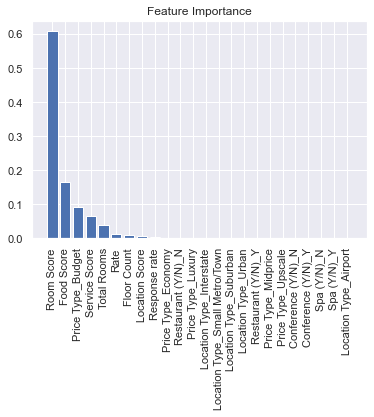

In [305]:
importances = rf.feature_importances_
sorted_indices = np.argsort(importances)[::-1]

plt.title('Feature Importance')
plt.bar(range(X_train.shape[1]), importances[sorted_indices], align='center')
plt.xticks(range(X_train.shape[1]), X_train.columns[sorted_indices], rotation=90)
plt.show()

From our feature importance graph above we observe that Room score, Food Score, Service Score, Budget Type and floor count are the top 5 features affecting the overall score, which is in line with our findings from the heatmap above.

Room score is the single most important indicator of the overall score. 

## 6 Recommendations & Limitations

### 6.1 Recommendations

1) Midprice Hotel with a restaurant in sub-urban area is the best choice of price type and location type for a new hotel in the Denver area.

2) On average a room price between $150 - $200 is justifiable based on the seasons.

3) The new hotel should have between 150 - 200 rooms and between 4 -7 floors to compete with the other hotels in the area.

4) Westminister is the ideal location to open the hotel as it is close to I-25 and about 35 minutes from Denver international airport and does not have a lot of other hotels to compete with unlike the main Denver area.

5) Having a Restaurant may lead to higher overall score.

6) Room Score and Food score are the main leading factors affecting the overall score. Having good budget friendly food option and clean rooms should be the highest priority of the new management for a higher overall score.

### 6.2 Limitations

1) A small subset of the dataset was used for understanding the performance of Denver hotel which makes our results less accurate.

2) The model and analysis is one of the simplest approach and could be improved by adding in more data and other important variables such as area of the land, revenue, occupancy rate and other metrics of the hotel that would help build better analysis and model.

3) Fuzzymatching should have been followed by manual error correcting to see if we could increase the size of the dataset.

4) On larger datasets we could use functions from recordlinkage package to improve the time spent on matching.

5) I have not considered seasonality in my analysis due to the lack of datetime related values. Adding a datetime component would enrich our analysis as it would help us understand the price and occupancy rates at different seasons of the year. 
